# Impact of OCR in linguistic processing

Tasks in this notebook:
- [ ] Part-of-speech tagging
- [ ] Named entity recognition
- [ ] Dependency parsing
- [ ] Semantic role labelling

Not considered here:
- Sentence splitting
- Tokenisation
- Lemmatisation

## Preprocessing the data

In [1]:
import sys
import argparse
from pathlib import Path
import spacy
import glob
import syntok.segmenter as segmenter
from spacy.tokens import Doc
from spacy.scorer import Scorer
from spacy.gold import GoldParse
import string
import pandas as pd
import jellyfish
import os

In [2]:
nlp = spacy.load("en_core_web_lg")

In [3]:
df = pd.read_pickle("db_sentence_ICDAR.pkl")

In [4]:
df.iloc[:3]

,doc_index,sent_index,OCR_aligned,GS_aligned,begin_index
1,eng_monograph_2017_289,eng_monograph_2017_289_1,BK. III. 364 AN ENGLISH ANTHOLOGY. Over many ...,####################################### many ...,0
2,eng_monograph_2017_289,eng_monograph_2017_289_161,"Now they look abroad to see, Now return and w...","Now they look abroad to see, Now return and w...",160
3,eng_monograph_2017_289,eng_monograph_2017_289_219,"Pitying, I dropped a tear But I saw a glow-wo...","Pitying, I dropped a tear But I saw a glow-wo...",218


## Add columns with cleaned text

Consider only sentences that humans could read (sentences without '#') and which have a lenght of more than 10 characters.

In [5]:
df = df[~df["GS_aligned"].str.contains('##')]
df = df[df["GS_aligned"].str.len() > 10]
df['GS_clean'] = df['GS_aligned'].str.replace('@', '')
df['OCR_clean'] = df['OCR_aligned'].str.replace('@', '')

In [6]:
df.head()

,doc_index,sent_index,OCR_aligned,GS_aligned,begin_index,GS_clean,OCR_clean
2,eng_monograph_2017_289,eng_monograph_2017_289_161,"Now they look abroad to see, Now return and w...","Now they look abroad to see, Now return and w...",160,"Now they look abroad to see, Now return and w...","Now they look abroad to see, Now return and w..."
3,eng_monograph_2017_289,eng_monograph_2017_289_219,"Pitying, I dropped a tear But I saw a glow-wo...","Pitying, I dropped a tear But I saw a glow-wo...",218,"Pitying, I dropped a tear But I saw a glow-wo...","Pitying, I dropped a tear But I saw a glow-wo..."
4,eng_monograph_2017_289,eng_monograph_2017_289_341,"I am set to light the ground, While the beetl...","I am set to light the ground, While the beetl...",340,"I am set to light the ground, While the beetl...","I am set to light the ground, While the beetl..."
7,eng_monograph_2017_289,eng_monograph_2017_289_484,TIME AND SORROW.,TIME AND SORROW.,483,TIME AND SORROW.,TIME AND SORROW.
8,eng_monograph_2017_289,eng_monograph_2017_289_501,O Time ! who know'st a lenient hand to lay So...,O TIME ! who know'st a lenient hand to lay So...,500,O TIME ! who know'st a lenient hand to lay So...,O Time ! who know'st a lenient hand to lay So...


In [7]:
df.shape

(35228, 7)

## Add columns with string similarity and length

In [8]:
def distance_via_levenshtein(gs_clean, ocr_clean):
    gs_clean = gs_clean.lower()
    ocr_clean = ocr_clean.lower()
    max_sentlength = max(len(gs_clean), len(ocr_clean))
    lev_distance = jellyfish.levenshtein_distance(gs_clean, ocr_clean)
    dist_similarity = (max_sentlength - lev_distance) / float(max_sentlength)
    return dist_similarity

In [9]:
df['str_similarity'] = df.apply(lambda row: distance_via_levenshtein(row['GS_clean'], row['OCR_clean']), axis = 1)
df['str_length'] = df.apply(lambda row: len(row['GS_clean']), axis = 1)

In [10]:
# Number of documents that have at least one sentence with string similarity lower than 0.8:
len(df[df['str_similarity'] < 0.8]['doc_index'].unique())

147

## OCR and GS string similarity distribution

Plot the distribution of sentences according to string similarity between OCR and GS text:

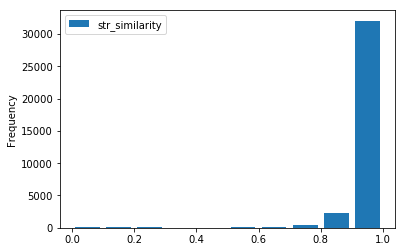

In [17]:
df[['str_similarity']].plot(kind='hist',bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],rwidth=0.8)

Get some examples from each bin:

In [49]:
df[(df['str_similarity'] > 0.8) & (df['str_similarity'] <= 0.9)].sample(6).loc[:, ['OCR_clean', 'GS_clean']]

,OCR_clean,GS_clean
35598,Ordered to lie on tile tabic.,Ordered to lie on the table.
29276,"On Tueaday. December 28. for Five Night Only,...","On Tuesday, December 28, for Five Nights Only..."
29268,FADDY DAWRR.,PADDY DAWER.
7806,"Mr. Blathers made a bow, and",Mr. Blathers made a bow.
29409,!n tho County Court of Darlisra. holdrn at St...,In the County Court of Durham. holden at Stoc...
37052,"Tbo parish had seat them to pick oakum, and t...","The parish had sent them to pick oakum, and t..."


## Add columns with spacy preprocessed text

In [43]:
if not os.path.isfile('db_sentence_spacy.pkl'):
    df['spacy_gs'] = df.apply(lambda row: nlp(row['GS_clean'].strip()), axis = 1)
    df['spacy_ocr'] = df.apply(lambda row: nlp(row['OCR_clean'].strip()), axis = 1)
    df.to_pickle('db_sentence_spacy.pkl')
else:
    df = pd.read_pickle('db_sentence_spacy.pkl')

In [46]:
df[df['str_similarity'] < 0.8]

,doc_index,sent_index,OCR_aligned,GS_aligned,begin_index,GS_clean,OCR_clean,str_similarity,str_length,spacy_gs,spacy_ocr
408,eng_monograph_2017_288,eng_monograph_2017_288_783,"- Cowper's Task, bk@@@@@","-@Cowper's Task, bk. vi.",782,"-Cowper's Task, bk. vi.","- Cowper's Task, bk",0.750000,24,"(-Cowper, 's, Task, ,, bk, ., vi, .)","(-, Cowper, 's, Task, ,, bk)"
1213,eng_monograph_2017_273,eng_monograph_2017_273_927,"From The Ghost, bk@@@@,","From The Ghost, bk. ii.",926,"From The Ghost, bk. ii.","From The Ghost, bk,",0.791667,24,"(From, The, Ghost, ,, bk, ., ii, .)","(From, The, Ghost, ,, bk, ,)"
1460,eng_monograph_2017_39,eng_monograph_2017_39_2345,Ot TC CHORUS.,@@@@C@@HORUS.,2344,CHORUS.,Ot TC CHORUS.,0.571429,8,"(CHORUS, .)","(Ot, TC, CHORUS, .)"
1485,eng_monograph_2017_11,eng_monograph_2017_11_2441,"Oh ! if I had, fca o ,","Oh ! if I had, @c@@@@.",2440,"Oh ! if I had, c.","Oh ! if I had, fca o ,",0.739130,18,"(Oh, !, if, I, had, ,, c.)","(Oh, !, if, I, had, ,, fca, o, ,)"
3270,eng_monograph_2017_744,eng_monograph_2017_744_4936,@Poor dear@@,'Poor dear!',4935,'Poor dear!',Poor dear,0.769231,13,"(', Poor, dear, !, ')","(Poor, dear)"
...,...,...,...,...,...,...,...,...,...,...,...
43625,en1_2019_24,en1_2019_24_23,@@ANTHOLOGY. @[bk. iv.,"Pallas, Oct. 10, 1836.",22,"Pallas, Oct. 10, 1836.",ANTHOLOGY. [bk. iv.,0.260870,23,"(Pallas, ,, Oct., 10, ,, 1836, .)","(ANTHOLOGY, ., [, bk, ., iv, .)"
43633,en1_2019_24,en1_2019_24_993,@@@@@@@@@@@@@@@@@@@@@@@@@@,IV. AN ENGLISH ANTHOLOGY.,992,IV. AN ENGLISH ANTHOLOGY.,,0.000000,26,"(IV, ., AN, ENGLISH, ANTHOLOGY, .)",()
43634,en1_2019_30,en1_2019_30_2,@GoMic@lLand Tragical — / HISTORY of the LIVES...,Comical and Tragical@@@@ HISTORY of the LIVES...,1,Comical and Tragical HISTORY of the LIVES and...,GoMiclLand Tragical — / HISTORY of the LIVES a...,0.669173,133,"(Comical, and, Tragical, HISTORY, of, the, LIV...","(GoMiclLand, Tragical, —, /, HISTORY, of, the,..."
43635,en1_2019_30,en1_2019_30_139,@@@@@@@@@@@@@@@@@@@@,Price One Shilling.,138,Price One Shilling.,,0.000000,20,"(Price, One, Shilling, .)",()


## Evaluate part-of-speech tagging

## In progress

### Evaluate tokenisation

In [50]:
def evaluate_aligned_tokens(ocr_sentence, gs_sentence):
    ocr_tok_sequence = dict()
    gs_tok_sequence = dict()
    
    for token in ocr_sentence:
        ocr_tok_sequence[token.idx] = token.text
    for token in gs_sentence:
        gs_tok_sequence[token.idx] = token.text
    
    

### Evaluate part-of-speech tagging

In [ ]:
def evaluate_aligned_pos_accuracy(ocr_sentence, gs_sentence):
    ocr_pos_sequence = dict()
    gs_pos_sequence = dict()
    for token in ocr_sentence:
        ocr_pos_sequence[token.idx] = (token.text, token.pos_)
    for token in gs_sentence:
        gs_pos_sequence[token.idx] = (token.text, token.pos_)

### Evaluate named entity recognition

[In progress]

In [ ]:
def evaluate_aligned_ner(ocr_sentence, gs_sentence):
    ocr_ner_sequence = dict()
    gs_ner_sequence = dict()
    for token in ocr_sentence:
        ocr_ner_sequence[token.idx] = (token.text, token.ent_type_, token.ent_iob_)
    for token in gs_sentence:
        gs_ner_sequence[token.idx] = (token.text, token.ent_type_, token.ent_iob_)
    
#     for k, v in gs_ner_sequence.items():
#         if k in ocr_ner_sequence:
#             print(k, ocr_ner_sequence[k], v)

### Compare OCR aligned with GS aligned

In [ ]:
for st in alignedSentences:
    st_boundaries = (st[0], st[1])
    
    # Filter out sentences which contain human uncertainties:
    if not '##' in st[3]:
        
        # Parse with spacy:
        aligned_ocr_sentence = nlp(st[2])
        aligned_gs_sentence = nlp(st[3])

        evaluate_aligned_tokens(aligned_ocr_sentence, aligned_gs_sentence)
        evaluate_aligned_pos(aligned_ocr_sentence, aligned_gs_sentence)
        evaluate_aligned_ner(aligned_ocr_sentence, aligned_gs_sentence)

    

In [ ]:
#     for token in nlp(ocr_sentence):
#         print(token.idx, token.text, token.lemma_, token.pos_, token.dep_, token.head, token.left_edge, token.right_edge, token.ent_type_, token.ent_iob_, token.is_oov)
#     print()
#     for token in nlp(gs_sentence):
#         print(token.idx, token.text, token.lemma_, token.pos_, token.dep_, token.head, token.left_edge, token.right_edge, token.ent_type_, token.ent_iob_, token.is_oov)
#     print()

**http://nlpprogress.com/english/dependency_parsing.html**

Evaluation metrics are unlabeled attachment score (UAS) and labeled attachment score (LAS). UAS does not consider the semantic relation (e.g. Subj) used to label the attachment between the head and the child, while LAS requires a semantic correct label for each attachment.Here, we also mention the predicted POS tagging accuracy.

https://linguistics.stackexchange.com/questions/6863/how-is-the-f1-score-computed-when-assessing-dependency-parsing